<a href="https://colab.research.google.com/github/cchen744/uhi-extreme-heat-response/blob/main/notebooks/01_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will quantify Urban Heat Isalnd Effect and Extreme Heat within one single city (Chicago). This data preprocessing workflow will be applited to more cities later.
Notably, here are following definitions of variables of interest:
- **Urban Heat Island**: Based on land surface temperture, it is defined as SUHI(day) = LST_urb(day) − LST_rur(day), where LST_urb(day) = Aggregate urban pixels (mean or median, predefined) and LST_rur(day) = Aggregate rural reference pixels.
- **Extreme Heat Window**: three consecutive days when the daily mean landsurface temperature overpasses 95 percentile of its historical data.
- **Urban & Rural Definition**：

  - Urban: US Census Urbanized Area
  - Rural: Spatial mean of all non-urban, non-water pixels within the same UA



In [5]:
# Core
import ee
import geemap
import pandas as pd
import numpy as np

In [2]:
ee.Authenticate()
ee.Initialize(project='extremeweatheruhi')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Global Parameters

In [6]:
CITY_NAME = "Chicago, IL"

START_DATE = "2013-06-01"
END_DATE   = "2019-08-31"

# LST choice = "Night"
LST_BAND = "LST_Night_1km"
QC_BAND  = "QC_Night"

# Aggregation choice
AGG_FUNC = "mean"

# Extreme heat definition (LST-based)
EXTREME_PERCENTILE = 95
EXTREME_CONSEC_DAYS = 3

# Pixel count threshold (drop day if too sparse)
MIN_URBAN_PIXELS = 30
MIN_RURAL_PIXELS = 30

Load Urbanized Area

In [12]:
ua = ee.FeatureCollection("projects/extremeweatheruhi/assets/uac20_2025")
city = ua.filter(ee.Filter.eq("NAME20", CITY_NAME))

# Sanity check
Map = geemap.Map()
Map.centerObject(city, 8)
Map.addLayer(city, {}, "Chicago UA")
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## 1. Data Extraction

### 1.2 Temperature data from PRISM

- For this section, we should output three time series tables:
  1. daily mean temperature in urban area
  2. daily mean temperature in non-urban area

    (Two tables above will be used to evaluate daily Urban Heat Island Effect)

  3. daily maximum temperature in urban area for identifying extreme heat periods

- The raw temperature data will be extracted from Google Earth Engine where PRISM data is available

In [ ]:
# First, define a function that transforms a daily temperature image into daily temperature feature
# This will be useful for the generation of the three tables we will use

def daily_to_feature(img, roi, band, tag):
  '''
  Convert a daily temperature image to a feature with date and tmean properties.
  img: the daily temperature image of roi from google earth engine.
  roi: region of interest (we will first experiment with Chicago).
  band: which band of the image are we using? could be tmean, tmax, tmedian, etc.
  tag: urban vs. nonurban.
  '''

  # 1) compute statistic over roi
  stat = img.reduceRegion(
      reducer=ee.Reducer.median(), # use median as a representation of one study unit
      geometry=roi,
      scale=4000, # 4km is one unit of study
      maxPixels=1e13
  )

  # 2) get date string
  date_str = img.date().format("YYYY-MM-dd")
  # 3) extract value (server-side)
  value = stat.get(band)            # We will mainly focus on tmean and tmax this time

  # 4) build feature with only the fields we want
  new_key = f"{band}_{tag}"  # build key client-side for stability (for example, new_key = 'tmean_urban')
  feat = ee.Feature(None, {}) \
      .set("date", date_str) \
      .set(new_key, value)

  # Optional: ensure only two columns exist
  feat = feat.select(["date", new_key])

  return feat

In [ ]:
# Load PRISM daily
prism = ee.ImageCollection("OREGONSTATE/PRISM/ANd")

## select only tmean
prism_tmean = prism.select("tmean")
## check bands
print(ee.Image(prism_tmean.first()).bandNames().getInfo())
## filter
prism_year = prism_tmean.filterDate('2005-01-01', '2026-01-01')
## check count
print("Count:", prism_year.size().getInfo())
## check first/last date
first_date = ee.Image(prism_year.sort("system:time_start").first()).date().format("YYYY-MM-dd").getInfo()
last_date  = ee.Image(prism_year.sort("system:time_start", False).first()).date().format("YYYY-MM-dd").getInfo()
print("First:", first_date, "Last:", last_date)

# A quick sanity check of temperature scale
roi = ee.Geometry.Point([-87.41, 41]).buffer(2000)
## pick one day, for example the first day, 2005-01-01
img0 = ee.Image(prism_year.first()).clip(roi)
## reduceRegion mean
stats = img0.reduceRegion(
    reducer=ee.Reducer.median(),
    geometry=roi,
    scale=4000,
    maxPixels=1e13
).getInfo()
print(stats)

['tmean']
Count: 7670
First: 2005-01-01 Last: 2025-12-31
{'tmean': 5.839000225067139}


Now apply the daily-to-features( ) function to generate three intended tables

In [ ]:
# ---- Apply the daily-to-features( ) to the collection ----
prism = ee.ImageCollection("OREGONSTATE/PRISM/ANd") # Get PRISM IMage collections from GEE
roi_placeholder = ee.Geometry.Point([-87.41, 41]).buffer(2000) # some point in Chicago urban area, just for experimenting, will be replaced later
prism_bands = prism.select(["tmean", "tmax"]); prism_year = prism_bands.filterDate('2005-01-01', '2026-01-01')

# Table 1: daily average temperature of urban area
fc_urban = ee.FeatureCollection(
    prism_year.map(lambda img: daily_to_feature(img, roi_placeholder, 'tmean','urban'))
)
print(fc_urban.size().getInfo())
print(fc_urban.first().propertyNames().getInfo())
print(fc_urban.first().getInfo()["properties"])

# Table 2: daily average temperature of non-urban area
fc_nonurban = ee.FeatureCollection(
    prism_year.map(lambda img: daily_to_feature(img, roi_placeholder, 'tmean','nonurban')) # We have not used the spatial masking yet, so the data for nonurban area right now is wrong. This step is just showing the schema of tmean_nonurban dataset
)
print(fc_nonurban.size().getInfo())
print(fc_nonurban.first().propertyNames().getInfo())
print(fc_nonurban.first().getInfo()["properties"])

# Table 3: daily maximum temperature of urban area (for identifying extreme heat)
fc_nonurban = ee.FeatureCollection(
    prism_year.map(lambda img: daily_to_feature(img, roi_placeholder, 'tmax','urban')) # We have not used the spatial masking yet, so the data for nonurban area right now is wrong. This step is just showing the schema of tmean_nonurban dataset
)
print(fc_nonurban.size().getInfo())
print(fc_nonurban.first().propertyNames().getInfo())
print(fc_nonurban.first().getInfo()["properties"])

7670
['system:index', 'date', 'tmean_urban']
{'date': '2005-01-01', 'tmean_urban': 5.839000225067139}
7670
['system:index', 'date', 'tmean_nonurban']
{'date': '2005-01-01', 'tmean_nonurban': 5.839000225067139}
7670
['system:index', 'date', 'tmax_urban']
{'date': '2005-01-01', 'tmax_urban': 12.23799991607666}


### 1.2 City Boundaries from US Census

City boundary data will be used to do masking, differentiating urban areas from non-urban areas
- Source: [US Census Urban](https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_ua10_500k.zip)

Shapefile loaded successfully:


,UACE20,GEOID20,GEOIDFQ20,NAME20,NAMELSAD20,LSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,11139,11139,400C200US11139,"Buckeye North, AZ","Buckeye North, AZ Urban Area",67,G3500,S,7276723,0,+33.6716952,-112.6230359,"MULTIPOLYGON (((-112.61257 33.65556, -112.6129..."
1,34286,34286,400C200US34286,"Grand Lake, CO","Grand Lake, CO Urban Area",67,G3500,S,13928266,149149,+40.2335164,-105.8560831,"MULTIPOLYGON (((-105.85759 40.25798, -105.8575..."
2,72620,72620,400C200US72620,"Pueblo West, CO","Pueblo West, CO Urban Area",67,G3500,S,57144582,36776,+38.3189075,-104.7570200,"MULTIPOLYGON (((-104.71603 38.36288, -104.7160..."
3,24539,24539,400C200US24539,"Douglas, MI","Douglas, MI Urban Area",67,G3500,S,10961033,1401554,+42.6532307,-086.1968772,"MULTIPOLYGON (((-86.21843 42.61536, -86.21862 ..."
4,81472,81472,400C200US81472,"Shenandoah--Frackville, PA","Shenandoah--Frackville, PA Urban Area",67,G3500,S,7587731,168615,+40.7986696,-076.2144386,"MULTIPOLYGON (((-76.22126 40.79827, -76.22108 ..."


CRS: EPSG:4269
Bounds: [-170.78931   -14.365419  145.791574   64.928893]
Rows: 2644
Columns: ['UACE20', 'GEOID20', 'GEOIDFQ20', 'NAME20', 'NAMELSAD20', 'LSAD20', 'MTFCC20', 'FUNCSTAT20', 'ALAND20', 'AWATER20']


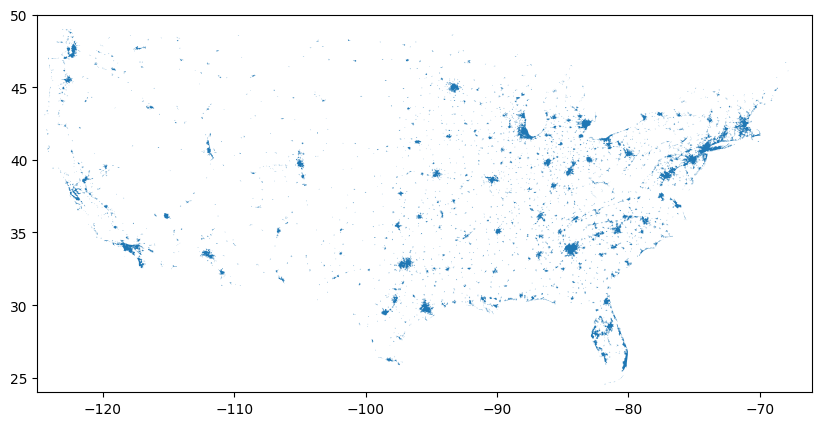

In [ ]:
# First we take a look at this dataset

# Replace with the actual path to your shapefile in Google Drive
shapefile_path = '/content/uhi-extreme-heat-response/data/urban_boundary/tl_2025_us_uac20.shp'

# Set GDAL environment variable to restore missing .shx file
os.environ['SHAPE_RESTORE_SHX'] = 'YES'

try:
    gdf = gpd.read_file(shapefile_path)
    print("Shapefile loaded successfully:")
    display(gdf.head())
    print("CRS:", gdf.crs)
    print("Bounds:", gdf.total_bounds)  # [minx, miny, maxx, maxy]
    print("Rows:", len(gdf))
    print("Columns:", list(gdf.columns)[:10])
except FileNotFoundError:
    print(f"Error: The shapefile at '{shapefile_path}' was not found. Please check the path and ensure all associated files are present.")
except Exception as e:
    print(f"An error occurred while reading the shapefile: {e}")

# Visualization
ax = gdf.plot(figsize=(10, 6), linewidth=0.1)
ax.set_xlim(-125, -66)
ax.set_ylim(24, 50)
plt.show()

Now we can start masking officially

In [ ]:
gdf = gpd.read_file('/content/uhi-extreme-heat-response/data/urban_boundary/tl_2025_us_uac20.shp')

# 1) Ensure CRS is WGS84 for EE compatibility
gdf_wgs84 = gdf.to_crs("EPSG:4326")

# 2) Filter Chicago urban area (adjust query_name if needed)
query_name = "Chicago"
chi = gdf_wgs84[gdf_wgs84["NAMELSAD20"].str.contains(query_name, case=False, na=False)].copy()

print("Matches:", len(chi))
print(chi[["NAME20","NAMELSAD20"]].head())

# 3）Though there is only one match, we still use dissolve to make it convenient for analyzing other cities
# As cities may be a multipolygon, dissolving it into a single geometry first is more stable.
chi1 = chi.dissolve()  # dissolve all selected features into one
chi1 = chi1.reset_index(drop=True)

# Convert to EE FeatureCollection then geometry
chi_fc = geemap.gdf_to_ee(chi1)
roi_urban = chi_fc.geometry()

# Quick sanity: print centroid (server-side -> client)
print("Urban centroid:", roi_urban.centroid().coordinates().getInfo())


Matches: 1
               NAME20                  NAMELSAD20
1896  Chicago, IL--IN  Chicago, IL--IN Urban Area
Urban centroid: [-87.906721595584, 41.82877632255679]


Creating non-urban buffering ring
- Inner buffer = 10 km (excluding transition zones adjacent to cities)
- Outer buffer = 50 km (ensuring sufficient size for the control area)

In [ ]:
inner_m = 10_000
outer_m = 50_000

roi_nonurban = roi_urban.buffer(outer_m).difference(roi_urban.buffer(inner_m))

# Optional sanity: check areas (m^2)
print("Urban area:", roi_urban.area().getInfo())
print("Nonurban ring area:", roi_nonurban.area().getInfo())

Urban area: 6147146944.8459
Nonurban ring area: 25074297669.03552


Now put the real urban area and non-urban area back into the daily-to-features( ) to get the 3 tables